In [99]:
import json
import pandas as pd
import os
from pathlib import Path
import sys

sys.path.append("../")


from config import DATA_DIR

In [100]:
logs_dir = DATA_DIR / "connectedness/mag_logs_2hop"
json_files = sorted([f for f in logs_dir.glob("*.json")])

data = []

for json_file in json_files:
    with open(json_file, "r") as f:
        log_data = json.load(f)

    # Extract key information from each log entry
    record = {
        "file_id": json_file.stem,
        "question": log_data.get("question", ""),
        "answer_indices": log_data.get("answer_indices", []),
        'sorted_candidates': log_data.get("sorted_candidates", []),
        "hit@1": log_data.get("hit@1", None),
        "hit@5": log_data.get("hit@5", None),
        "recall@20": log_data.get("recall@20", None),
    }

    data.append(record)
    
df = pd.DataFrame(data)

In [101]:
df.head()

,file_id,question,answer_indices,sorted_candidates,hit@1,hit@5,recall@20
0,0,Does any research from the Indian Maritime Uni...,[1600189],"[1600189, 1254035]",True,True,1.000000
1,1,Show me articles related to magnetic field stu...,[1265762],"[1265762, 1390758, 1584269, 1185665, 1275328, ...",True,True,1.000000
2,10,"Show me publications from the co-authors of ""C...","[1521384, 1578676, 1289934]","[1422742, 1361436, 1492642, 1424718, 1365479, ...",False,False,0.666667
3,11,Show me publications by Jianxin Ma on new tech...,[1686364],"[1779954, 1622059, 1414886, 1436282, 1300727, ...",False,False,0.000000
4,12,Are there any publications from 2015 with shar...,[1660601],"[1660601, 1251389, 1674818, 1824257, 1304392, ...",True,True,1.000000


In [102]:
df['recall@20'].mean()

np.float64(0.7876984126984126)

In [103]:
import matplotlib.pyplot as plt
import numpy as np

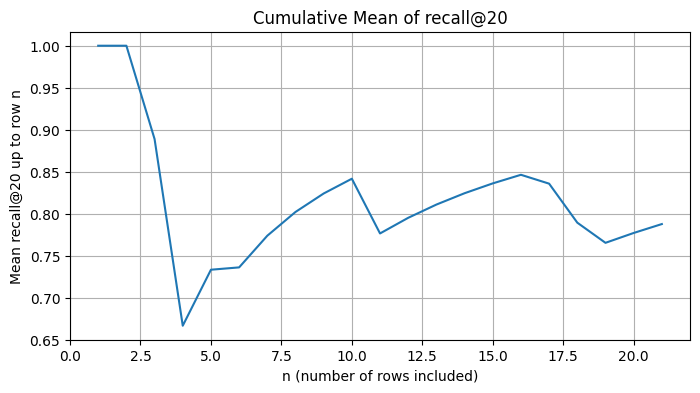

In [104]:
column = 'recall@20'

df['index'] = df.index
df = df.sort_values('index').reset_index(drop=True)

means = df[column].expanding().mean()
n_rows = np.arange(1, len(means) + 1)

plt.figure(figsize=(8, 4))
plt.plot(n_rows, means)
plt.xlabel("n (number of rows included)")
plt.ylabel(f"Mean {column} up to row n")
plt.title(f"Cumulative Mean of {column}")
plt.grid(True)
plt.show()